# Analysis 5

Question: What relationships exist between the revenue range and the features of the offering, such as the type of securities, the type of industry which offerings belong to and the duration of offerings?

Method: Nonlinear Dimension Reduction

First, we define columns of interest for this analysis, including the type of securities, type of industry, duration of offering and the revenue range.

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.util import mark_negation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
plt.style.use("seaborn")

In [ ]:
selected_cols = ['INDUSTRYGROUPTYPE', 'MORETHANONEYEAR', 'ISEQUITYTYPE', 'ISDEBTTYPE', \
          'ISOPTIONTOACQUIRETYPE', 'ISSECURITYTOBEACQUIREDTYPE', \
          'ISPOOLEDINVESTMENTFUNDTYPE', 'ISTENANTINCOMMONTYPE', \
          'ISMINERALPROPERTYTYPE', 'ISOTHERTYPE']
target_col = ['REVENUERANGE']

We will apply dimension reduction to the selected columns, ie. type of securities and industries, as well as the duration of offerings. The gower distance is used because it is applicable to categorical variables.

In [ ]:
import gower
selected_cat_cols = ['INDUSTRYGROUPTYPE']
distmat = gower.gower_matrix(df[selected_cols], \
                             weight=None, 
                             cat_features=[(col in selected_cat_cols) \
                             for col in selected_cols])
# np.save('gower_dist.npy', distmat)
# distmat = np.load('gower_dist.npy')

We apply the Isomap method to perform dimension reduction based on the calculated Gower distance. We experiment with different parameter values of n_neighbors and n_components, in order to to determine the low dimension representation that makes the relationship between offering features and revenue clear. For conciseness of the notebook, only the best parameter values are shown below.

In [ ]:
from sklearn.manifold import Isomap

isoout = Isomap(n_neighbors=10, n_components=3).fit_transform(distmat)
np.save('isoout.npy', isoout)
#isoout = np.load('isoout.npy')

We merge the original data with the results of dimension reduction for plotting purposes. The combination is done so that we can reveal the correspondance between the low dimensional space and the original feature values. 

In [ ]:
df_iso = pd.concat([df[selected_cols+target_col], \
                    pd.DataFrame(isoout,\
                                 columns=['iso1', 'iso2', 'iso3'])], \
                                 axis=1)

There are a total of 35 different industries in the data set. Initially, we tried to include all of them on the graph via color-coding. However, this will introduce too many colors on the graph, and the distinction between some colors are so small, which makes intrepreting the graph difficult. Thus, we limit our graph to show only top 10 industries with the most data points. 

In [ ]:
df_iso.INDUSTRYGROUPTYPE.unique()

['Pooled Investment Fund', 'Other Technology', 'Other', 'Biotechnology', 'REITS and Finance', ..., 'Coal Mining', 'Electric Utilities', 'Health Insurance', 'Tourism and Travel Services', 'Airlines and Airports']
Length: 35
Categories (35, object): ['Agriculture', 'Airlines and Airports', 'Biotechnology', 'Business Services', ..., 'Restaurants', 'Retailing', 'Telecommunications', 'Tourism and Travel Services']

In [ ]:
all_industry = df.groupby('INDUSTRYGROUPTYPE')['ACCESSIONNUMBER'].count().sort_values(ascending=False)
top_industry = all_industry[:10]
top_industry = top_industry.index.to_list()

In [ ]:
nontop_industry = [ind for ind in all_industry.index.to_list() if ind not in top_industry]
len(nontop_industry)

25

We reset the number of categoricals after filtering for the top 10 industries.

In [ ]:
df_iso = df_iso[df_iso['INDUSTRYGROUPTYPE'].isin(top_industry)]
df_iso.INDUSTRYGROUPTYPE = df_iso.INDUSTRYGROUPTYPE.cat.remove_categories(nontop_industry)

Some records are for offerings that are associated with more than 1 security type. We tried to show these on the graph initially. However, this will introduce too many different combinations of security types. Similar to the industry type, the graph difficult to intrepret. Thus, we focus the plot on offerings that are only associated with 1 security type.

In [ ]:
df_iso = df_iso[df_iso[selected_cols[2:]].sum(axis=1) == 1]

We create a column that summarize the security type for plotting purposes.

In [ ]:
def security_type(row):
    label = ''
    if row['ISEQUITYTYPE']:
        return 'equity'
    if row['ISDEBTTYPE']:
        return 'debt'
    if row['ISOPTIONTOACQUIRETYPE']:
        return 'option'
    if row['ISSECURITYTOBEACQUIREDTYPE']:
        return 'to be acquired'
    if row['ISPOOLEDINVESTMENTFUNDTYPE']:
        return 'pooled investment fund'
    if row['ISTENANTINCOMMONTYPE']:
        return 'tenant in common'
    if row['ISMINERALPROPERTYTYPE']:
        return 'mineral property'
    if row['ISOTHERTYPE']:
        return 'other'

df_iso['security_type'] = df_iso.apply(lambda row: security_type(row), axis=1)

We looked at the low dimensional representation from different angles by trying to plot different combinations of the coordinates. 

The first two coordinates contain information that preserve distances in the original data best, and they reveal the relationship between offering features and revenues most clearly. Thus, we plot these two axes below. We include four graphs for 1) revenue, 2) security type, 3) industry type, and 4) if the duration is longer than 1 year. 

We look at the revenue graph to identify regions in the low dimensional space that corresponds to different revenue ranges. Then, we match these regions (and the data points) with the industry, security and duration graphs, which reveals the relationship between revenue ranges and these 3 offering features.

The observations are explained in the report.

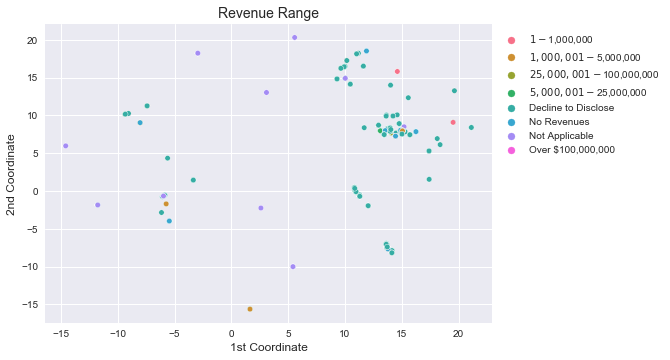

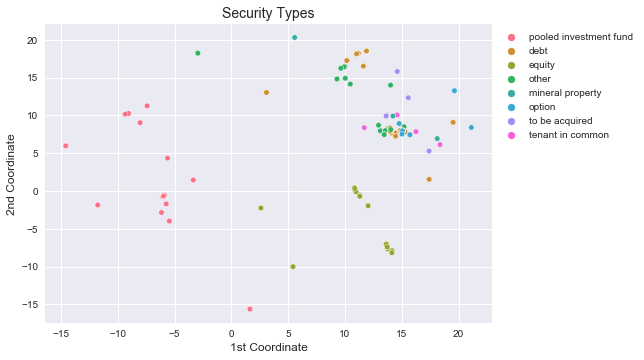

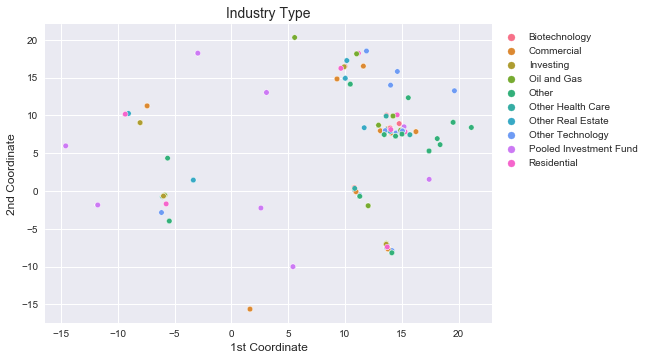

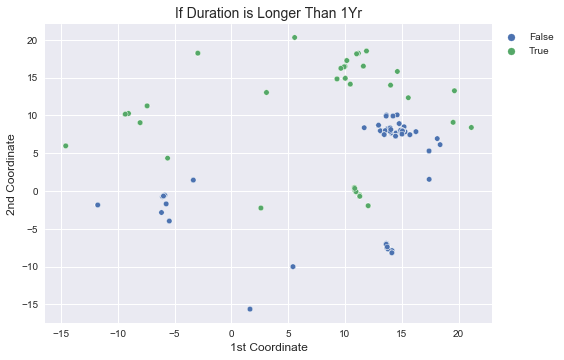

In [ ]:
sns.scatterplot(x='iso1', y='iso2', \
                data=df_iso, s=30,
                hue='REVENUERANGE')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('1st Coordinate', size=12)
plt.ylabel('2nd Coordinate', size=12)
plt.title('Revenue Range', size=14)
plt.show()

sns.scatterplot(x='iso1', y='iso2', \
                     data=df_iso, s=30,
                     hue='security_type')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('1st Coordinate', size=12)
plt.ylabel('2nd Coordinate', size=12)
plt.title('Security Types', size=14)
plt.show()   

ax = sns.scatterplot(x='iso1', y='iso2', \
                     data=df_iso, s=30,
                     hue='INDUSTRYGROUPTYPE')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('1st Coordinate', size=12)
plt.ylabel('2nd Coordinate', size=12)
plt.title('Industry Type', size=14)
plt.show()  

ax = sns.scatterplot(x='iso1', y='iso2', \
                     data=df_iso, s=30,
                     hue='MORETHANONEYEAR')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xlabel('1st Coordinate', size=12)
plt.ylabel('2nd Coordinate', size=12)
plt.title('If Duration is Longer Than 1Yr', size=14)
plt.show()   

We also tried to examine the low dimension space via 3D plots that include all 3 coordinates. Nevertheless, we determine that 3D plots do not reveal too much more information, compared to the 2D plots above. Also, 3D plots are harder for readers to interpret in the report because in the pdf document, readers cannot rotate the graph or hover over data points to see the details of the data. Thus, we only included 2D plots in the report.

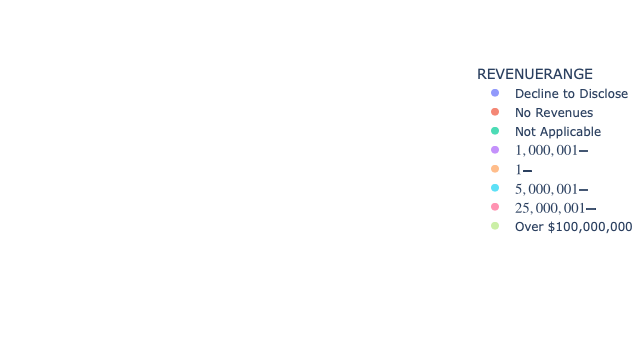

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_iso, x='iso1', 
   y='iso2', z='iso3', hover_data=["INDUSTRYGROUPTYPE", "security_type", "MORETHANONEYEAR"],
   color="REVENUERANGE", opacity=0.7)
fig.show()